In [9]:
# program that simulates the evolution of the firm's leverage 

# Import required libraries
import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fmin
import matplotlib.transforms as mtransforms
from scipy.optimize import minimize

# baseline parameters
μ = .02
r = .05
c = .08
ξ = 1/10000
c = 1
# tax benefits
τ = .1 # baseline is .1
# volatility parameters
λ = 1/3
σ = .25
σ2 = σ**2
η=17/3 # paratemeter of exponential distribution of downward jumps
ζ = η/(η+1)-1 # expected size of jumps
print(ζ)
ϕ = (1-τ)/(r-μ)
μhat = μ-ζ*λ
ρ = (c*(1-τ)+ξ)/(r+ξ)
zero = .0000001 # we add this quantity to avoid division by zero warning

-0.15000000000000002


In [10]:
# optimal TICR computation
# computing MPE for the constraint yb<=ybm
# find roots of characteristic equation
coefγ = [-σ2/2, μhat+ξ-σ2/2+σ2*η/2, r+λ+ξ-(μhat+ξ-σ2/2)*η, -r*η-ξ*η]
γs = sorted(np.roots(coefγ)); 
γ0 = γs[0]; γ1 = γs[1]; γ2 = γs[2] # gammas
print(γs)
M = np.array([[1,1,ϕ],[γ1,γ2,-ϕ],[η/(η-γ1),η/(η-γ2),ϕ*η/(η+1)]]) 
x = np.array([ρ,0,ρ])
[cm1,cm2,ybm] = np.linalg.solve(M,x) # coefficients of equity value functions and default boundary in MPE
em = lambda y: (ϕ*y-ρ  +cm1*(y/ybm)**(-γ1)+cm2*(y/ybm)**(-γ2)) * (y>ybm)
pm = lambda y: (ρ-(γ1+1)*cm1*(y/ybm)**(-γ1)-(γ2+1)*cm2*(y/ybm)**(-γ2)) * (y>ybm)
# bond pricing
def pfu(xha,xr):
    M = np.array([[1,1,1],[η/(η-γ0),η/(η-γ1),η/(η-γ2)],\
                  [xr**(-γ0)*(r+ξ-λ*(xha/xr)**(-η)*γ0/(η-γ0)),\
                   xr**(-γ1)*(r+ξ-λ*(xha/xr)**(-η)*γ1/(η-γ1)),\
                   xr**(-γ2)*(r+ξ-λ*(xha/xr)**(-η)*γ2/(η-γ2))]])
    x = np.array([-1,-1,0])
    b = np.linalg.solve(M,x)
    pha = (c+ξ)/(r+ξ)*(1+b[0]*xr**(-γ0)+b[1]*xr**(-γ1)+b[2]*xr**(-γ2))
    return [pha,b[0],b[1],b[2]]
# equity pricing
def efu(xha,xr):
    [pha,b0,b1,b2] = pfu(xha,xr)
    M = np.array([[1,1,1,ϕ,0],\
                  [γ0,γ1,γ2,-ϕ,0],\
                  [η/(η-γ0),η/(η-γ1),η/(η-γ2),ϕ*η/(η+1),0],\
                  [xr**(-γ0-1),xr**(-γ1-1),xr**(-γ2-1),ϕ,-1/xha],\
                  [λ*η/(η-γ0)*xr**(-γ0),\
                   λ*η/(η-γ1)*xr**(-γ1),\
                   λ*η/(η-γ2)*xr**(-γ2),\
                  (1-τ)*xha**(η+1)/xr**η + λ*ϕ*η*xr/(η+1),\
                  -((r-μhat+λ/(η+1))*(xha/xr)**η+λ*η*xr/(η+1)/xha)]])
    x = np.array([ρ, 0, ρ, pha/xha-(pha-ρ)/xr, λ*ρ+(c*(1-τ)+ξ)*(xha/xr)**η-pha*((μhat+ξ-λ/(η+1))*(xha/xr)**η-λ*η*xr/(η+1)/xha+λ)])
    [c0,c1,c2,yb,eha] = np.linalg.solve(M,x)
    return [c0,c1,c2,yb,eha]
# compute firm value function
def opt_func(x):
    xha = x[0]; xr = x[1]
    [pha,b0,b1,b2] = pfu(xha,xr)
    [c0,c1,c2,yb,eha] = efu(xha,xr)
    opt = -(eha+pha)/xha/yb
    if (yb>ybm)|(xha<=xr)|(xr<=1): opt=0
    return opt
# compute firm value function with commitment
def opt_func_comm(x):
    xha = x[0]; xr = x[1]
    [pha,b0,b1,b2] = pfu(xha,xr)
    [c0,c1,c2,yb,eha] = efu(xha,xr)
    opt = -(eha+pha)/xha/yb
    if (xha<=xr)|(xr<=1)|(yb<0): opt=0
    return opt
# find no-commitment optimum
x0 = np.array([120,100])    
xTICR,WTICR,iter,funcalls, warnflag = fmin(opt_func,x0,args=(),full_output=True,disp=0)
xha0 = xTICR[0]; xr0 = xTICR[1]
print(xTICR,WTICR)
[pha,b0,b1,b2] = pfu(xha0,xr0)
[c0,c1,c2,yb,eha] = efu(xha0,xr0)
print(c0,c1,c2)
print(b0,b1,b2)
yha0=xha0*yb
yrT=xr0*yb
ybT = yb
pfunc = lambda y: (c+ξ)/(r+ξ)*(1+b0*(y/yb)**(-γ0)+b1*(y/yb)**(-γ1)+b2*(y/yb)**(-γ2))*(yrT>=y>yb)+pha*(y>yrT)
efunc = lambda y: (ϕ*y-ρ+c0*(y/yb)**(-γ0)+c1*(y/yb)**(-γ1)+c2*(y/yb)**(-γ2))*(yrT>=y>yb)+(eha*y/yha0+(y/yha0-1)*pha)*(y>yrT)
print('yha0=',yha0,'yr0=',yrT,'yb=',ybT,ybm,(pha+eha)/yha0)


[-1.4056095268950302, 0.8678231754264448, 7.447653018135258]
[9.94785085 7.97244907] -30.808111849982474
2.075611683493502e-11 9.220000992883673 0.08815896329053001
0.004092871443874604 -0.9622843676413898 -0.04180850380248486
yha0= 2.8709192172774602 yr0= 2.3008243288395214 yb= 0.28859693026921657 0.28859693027004846 30.808111849982474


/Users/atsoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/atsoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/Users/atsoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/atsoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
yha0 = 2.88687
yr0  = 2.31472
yb0  = 0.2888

In [ ]:
# find optimal policy in Fischer, Heinkel, Zechner (1989)

In [3]:
def simulated_lvrg(Y0=1, F0=1, T=1, Nsteps=252, Nsim=1, seed=None):                   
    # parameters of the debt policy
    xha = yha/yb; xr = yr/yb
    # compute various parameters of the model
    ζ = η/(η+1)-1
    μhat = μ-ζ*λ
    σ2 = σ**2
    ϕ = (1-τ)/(r-μ)
    ρ = (1-τ)/r
    coefγ = [-σ2/2, μhat-σ2/2+σ2*η/2, r+λ-μhat*η+σ2*η/2, -r*η]
    γs = sorted(np.roots(coefγ)); γ0 = γs[0]; γ1 = γs[1]; γ2 = γs[2]
    # compute debt pricing    
    A = np.array([[1,1,1],[η/(η-γ0),η/(η-γ1),η/(η-γ2)],\
                  [xr**(-γ0)*(r-λ*(xha/xr)**(-η)*γ0/(η-γ0)),\
                   xr**(-γ1)*(r-λ*(xha/xr)**(-η)*γ1/(η-γ1)),\
                   xr**(-γ2)*(r-λ*(xha/xr)**(-η)*γ2/(η-γ2))]])
    b = np.array([-1,-1,0])
    [b0,b1,b2] = np.linalg.solve(A,b)
    pha = 1/r*(1+b0*xr**(-γ0)+b1*xr**(-γ1)+b2*xr**(-γ2))
    #compute equity pricing
    A = np.array([[1,1,1,ϕ,0],\
              [γ0,γ1,γ2,-ϕ,0],\
              [η/(η-γ0),η/(η-γ1),η/(η-γ2),ϕ*η/(η+1),0],\
              [xr**(-γ0-1),xr**(-γ1-1),xr**(-γ2-1),ϕ,-1/xha],\
              [λ*η/(η-γ0)*xr**(-γ0),\
               λ*η/(η-γ1)*xr**(-γ1),\
               λ*η/(η-γ2)*xr**(-γ2),\
              (1-τ)*xha**(η+1)/xr**η + λ*ϕ*η*xr/(η+1),\
              -((r-μhat+λ/(η+1))*(xha/xr)**η+λ*η*xr/(η+1)/xha)]])
    b = np.array([ρ, 0, ρ, pha/xha-(pha-ρ)/xr, λ*ρ+(1-τ)*(xha/xr)**η-pha*((μhat-λ/(η+1))*(xha/xr)**η-λ*η*xr/(η+1)/xha+λ)])
    [c0,c1,c2,yb,vha] = np.linalg.solve(A,b)

    pfunc = lambda y: 1/r*(1+b0*(y/yb)**(-γ0)+b1*(y/yb)**(-γ1)+b2*(y/yb)**(-γ2))*(yr>=y>yb)+pha*(y>yr)
    vfunc = lambda y: (ϕ*y-ρ+c0*(y/yb)**(-γ0)+c1*(y/yb)**(-γ1)+c2*(y/yb)**(-γ2))*(yr>=y>yb)+vha*(y>yr)
    
    # DeMarzo-He MPE calcluations
    Bm = np.array([[1,1],[γ1,γ2]])
    cm0 = np.linalg.solve(Bm,np.array([ρ,0]))
    cm1 = np.linalg.solve(Bm,np.array([-ϕ,ϕ]))
    ybm = (ρ - cm0[0]*η/(η-γ1) - cm0[1]*η/(η-γ2))/(ϕ*η/(η+1) + cm1[0]*η/(η-γ1) + cm1[1]*η/(η-γ2))
    Bm = np.array([[1,1],[γ1,γ2]])
    invBm = np.linalg.inv(Bm)
    cm = invBm@(ρ-ϕ*ybm,ϕ*ybm)
    vm = lambda y: (ϕ*y-ρ  +cm[0]*(y/ybm)**(-γ1)+cm[1]*(y/ybm)**(-γ2)) * (y>ybm)
    pm = lambda y: (ρ-(γ1+1)*cm[0]*(y/ybm)**(-γ1)-(γ2+1)*cm[1]*(y/ybm)**(-γ2)) * (y>ybm)
    gm = lambda y: τ/(γ1*(γ1+1)*cm[0]*(y/ybm)**(-γ1)+γ2*(γ2+1)*cm[1]*(y/ybm)**(-γ2)) * (y>ybm)
    um = lambda y: -(vm(y)+pm(y))/y  
    
    # Leland-94 calculations
    ybL = ybm # default threshold is as in DeMarzo-He
    A = np.array([[1,1],[η/(η-γ1),η/(η-γ2)]])
    b = np.array([-1,-1])
    bL = np.linalg.solve(A,b)
    vL = lambda y: vm(y)
    pL = lambda y: 1/r*(1+bL[0]*(y/ybm)**(-γ1)+bL[1]*(y/ybm)**(-γ2))*(y>=ybm)
    uL = lambda y: -(vL(y)+pL(y))/y
    ymaxL = fmin(uL,ybm*1.1,disp=False)
    F0L = Y0/ymaxL
    
    # Set random seed
    np.random.seed(seed)
    tic = time.time()
    # Calculate the length of the time step
    
    Delta_t = T/Nsteps
    Y_path  = np.zeros(Nsteps+1) # path of cash flows
    yt_path = np.zeros(Nsteps+1) # path of ICR
    xt_path = np.zeros(Nsteps+1) # normalized ICR
    F_path  = np.zeros(Nsteps+1) # debt dynamics
    p_path  = np.zeros(Nsteps+1) # debt price
    v_path  = np.zeros(Nsteps+1) # normalized equity
    LR_path = np.zeros(Nsteps+1) # LR 
    EV_path = np.zeros(Nsteps+1) # firm value
    int_yt  = 0 # auxiliary quantity equal to the new yt if there is no debt issuance/repurchase
    
    # DeMarzo-He leverage dynamics
    yt_DH = np.zeros(Nsteps+1) # ICR dynamics
    F_DH  = np.zeros(Nsteps+1) # debt dynamics
    p_DH  = np.zeros(Nsteps+1) # debt price
    v_DH  = np.zeros(Nsteps+1) # normalized equity
    g_DH  = np.zeros(Nsteps+1) # rate of debt issuance
    LR_DH = np.zeros(Nsteps+1) # LR 
    EV_DH = np.zeros(Nsteps+1) # firm value    
    # Leland94 leverage dynamics
    yt_Le = np.zeros(Nsteps+1) # ICR dynamics
    F_Le  = np.zeros(Nsteps+1) # debt dynamics
    p_Le  = np.zeros(Nsteps+1) # debt price
    v_Le  = np.zeros(Nsteps+1) # normalized equity
    LR_Le = np.zeros(Nsteps+1) # LR 
    EV_Le = np.zeros(Nsteps+1) # firm value        

    # Replace the first column of the array with the vector of initial price S
    Y_path[0] = Y0
    F_path[0] = F0 
    yt_path[0] = Y0/F0
    xt_path[0] = yt_path[0]/yb
    p_path[0] = pha
    v_path[0] = vha
    LR_path[0] = pha/(vha+pha)
    EV_path[0] = (vha+pha)*F0
    # initial conditions for DeMarzo-He MPE
    F_DH[0] = F0
    yt_DH[0] = Y0/F0
    p_DH[0] = pm(Y0/F0)
    v_DH[0] = vm(Y0/F0)
    LR_DH[0] = pm(Y0/F0)/(pm(Y0/F0)+vm(Y0/F0))    
    # initial conditions for Leland-94
    F_Le[0] = F0L
    yt_Le[0] = Y0/F0L
    p_Le[0] = pL(Y0/F0L)    
    v_Le[0] = vL(Y0/F0L)
    LR_Le[0] = pL(Y0/F0L)/(pL(Y0/F0L)+vL(Y0/F0L)) 
    
    Z_1 = np.random.normal(0,1,Nsteps)
    Z_2 = np.random.exponential(1/η, Nsteps)
    Poisson = np.random.poisson(λ*Delta_t, Nsteps)

    # Populate the matrix with Nsim randomly generated paths of length Nsteps
    for i in range(Nsteps):
        # fill out path for Yt
        Y_path[i+1] = (yt_path[i]<=yb) * Y_path[i] \
              + (yt_path[i]>yb) * Y_path[i] *np.exp((μhat- σ2/2)*Delta_t \
              + σ*np.sqrt(Delta_t)*Z_1[i] \
              - (Poisson[i]==1) * Z_2[i])
        # equilibrium dynamics
        # auxiliary yt if there was no additional debt issuance/repurchase
        int_yt = yt_path[i]*np.exp((μhat-σ2/2)*Delta_t \
              + σ*np.sqrt(Delta_t)*Z_1[i] \
              - (Poisson[i]==1) * Z_2[i])
        yt_path[i+1] = (yt_path[i]<=yb) * yt_path[i] \
                + (yt_path[i]>yb) * (int_yt<yr) * int_yt \
                + (yt_path[i]>yb) * (int_yt>=yr) * yha
        xt_path[i+1] = yt_path[i+1]/yb
        F_path[i+1] = (yt_path[i]>yb) * ((int_yt<yr) * F_path[i] \
                + (int_yt>=yr) * Y_path[i+1]/(yt_path[i+1]+zero))
        p_path[i+1] = pfunc(yt_path[i+1])
#         p_path[:,i+1] =  0*(xt_path[:,i+1]<=1)\
#             +1/r*(1+b0*xt_path[:,i+1]**(-γ0)+b1*xt_path[:,i+1]**(-γ1)+b2*xt_path[:,i+1]**(-γ2))*(yt_path[:,i+1]>yb)*(yt_path[:,i+1]<=yr)\
#             +pha*(yt_path[:,i+1]>yr)
        v_path[i+1] = vfunc(yt_path[i+1])
#         v_path[:,i+1] = 0*(yt_path[:,i+1]<=yb)\
#             +(ϕ*yb*xt_path[:,i+1]-ρ+c0*xt_path[:,i+1]**(-γ0)+c1*xt_path[:,i+1]**(-γ1)+c2*xt_path[:,i+1]**(-γ2))*(yt_path[:,i+1]>yb)*(yt_path[:,i+1]<=yr)\
#             +vha*(yt_path[:,i+1]>yr)
        if yt_path[i]<=yb:
            LR_path[i+1]=1
        else:    
            LR_path[i+1] = p_path[i+1]/(p_path[i+1]+v_path[i+1]+zero)
        EV_path[i+1] = (p_path[i+1]+v_path[i+1])*F_path[i+1]

        # DeMarzo-He dynamics
        g_DH[i] = gm(yt_DH[i])
        F_DH[i+1] = (yt_DH[i]>ybm)*F_DH[i]*(1+g_DH[i]*Delta_t)
        yt_DH[i+1] = (yt_DH[i]>ybm)*Y_path[i+1]/F_DH[i+1]+zero
        p_DH[i+1] = pm(yt_DH[i+1])
        v_DH[i+1] = vm(yt_DH[i+1])
        if yt_DH[i+1]<=ybm:
            LR_DH[i+1]=1
        else:    
            LR_DH[i+1] = p_DH[i+1]/(p_DH[i+1]+v_DH[i+1]+zero)        
#         Leland94 dynamics
        F_Le[i+1] = F0L
        yt_Le[i+1] = (yt_Le[i]>ybL)*Y_path[i+1]/F0L
        p_Le[i+1] = pL(yt_Le[i+1])        
        v_Le[i+1] = vL(yt_Le[i+1])
        if yt_Le[i+1]<=ybL:
            LR_Le[i+1]=1
        else:    
            LR_Le[i+1] = p_Le[i+1]/(p_Le[i+1]+v_Le[i+1]+zero)

    # mean debt prices 
    print(np.mean(1/p_path-r))
    print(np.mean(1/p_DH-r))
    print(np.mean(1/p_Le-r))
    # plot Y 
    sns.set(palette='viridis')
    plt.figure(figsize=(10,3.5))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1)
    Y_process = ax.plot(t, Y_path.transpose());
    plt.setp(Y_process, linewidth=2,color='green', label='Cash Flow Dynamics             ');
    ax.set(title="Cash Flows", xlabel='Time', ylabel='$Y_t$')
    plt.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.) 
    plt.xlim((-.1,10))
    plt.show()        

    # plot yt
    sns.set(palette='viridis')
    plt.figure(figsize=(10,3.5))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1)
    yt_process = ax.plot(t, yt_path.transpose());
    yDH_process = ax.plot(t, yt_DH.transpose());
    yLe_process = ax.plot(t, yt_Le.transpose())
    plt.setp(yt_process, linewidth=2,color='blue',label='Optimal Time-Consistent Policy');
    plt.setp(yDH_process, linewidth=2,color='orange',linestyle=(0, (1, 3)),label='DeMarzo, He (2019)');
    plt.setp(yLe_process, linewidth=2,color='red',linestyle=(0, (3, 3)),label='Leland (1994)');        
    # determine range of ys
    miny = min(yt_path); miny=min(miny,min(yt_DH));  miny=.9*min(miny,min(yt_Le));
    maxy = max(yt_path); maxy=max(maxy,max(yt_DH));  maxy=1.1*max(maxy,max(yt_Le));   
#     trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)    
#     ax.fill_between(t, 0.1, 5, where=yt_path < yha,
#                 facecolor='gray', alpha=0.2, transform=trans)
    # highlight turbulent region
    ax.fill_between(t, miny, maxy, where=yt_path < yha, facecolor='gray', alpha=0.2)                    
    ax.set(title="Interest Coverage Ratio", xlabel='Time', ylabel='$y_t/c$')
#     plt.legend(loc='upper right', borderaxespad=0.)
    plt.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)   
    plt.xlim((-.1,10))
    plt.ylim((miny,maxy))    
    plt.show()

    # plot F
    sns.set(palette='viridis')
    plt.figure(figsize=(10,3.5))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1)
    F_process = ax.plot(t, F_path.transpose());
    FDH_process = ax.plot(t, F_DH.transpose());
    FLe_process = ax.plot(t, F_Le.transpose());    
    plt.setp(F_process, linewidth=2, color='blue', label='Optimal Time-Consistent Policy');
    plt.setp(FDH_process, linewidth=2, color='orange',label='DeMarzo, He (2019)',linestyle=(0, (1, 3)));    
    plt.setp(FLe_process, linewidth=2, color='red',label='Leland (1994)',linestyle=(0, (3, 3)));        
    ax.set(title="Debt", xlabel='Time', ylabel='$F_t$')
    # determine range of Fs
    minF = min(F_path); minF=min(minF,min(F_DH));  minF=.9*min(minF,min(F_Le));
    maxF = max(F_path); maxF=max(maxF,max(F_DH));  maxF=1.1*max(maxF,max(F_Le));  
    # highlight turbulent region
#     trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(t, minF, maxF, where=yt_path < yha, facecolor='gray', alpha=0.2)
    plt.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)   
#     plt.legend(loc='upper right', borderaxespad=0.)
    plt.xlim((-.1,10))
    plt.ylim((minF,maxF))      
    plt.show()    
       

#     # plot gmt
#     sns.set(palette='viridis')
#     plt.figure(figsize=(10,4))
#     ax = plt.axes()
#     t = np.linspace(0, T, Nsteps+1)
#     g_process = ax.plot(t, g_DH.transpose());
#     plt.setp(g_process, linewidth=1);
#     ax.set(title="Debt issuance rate in DeMarzo-He", \
#        xlabel='Time', ylabel='$g_t$')
#     plt.show()

    # plot pt
    sns.set(palette='viridis')
    plt.figure(figsize=(10,3.5))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1)
    pt_process = ax.plot(t, p_path.transpose());
    pDH_process = ax.plot(t, p_DH.transpose());
    pLe_process = ax.plot(t, p_Le.transpose());    
    plt.setp(pt_process, linewidth=2, color='blue', label='Optimal Time-Consistent Policy');
    plt.setp(pDH_process, linewidth=2, color='orange', label='DeMarzo, He (2019)',linestyle=(0, (1, 3)));    
    plt.setp(pLe_process, linewidth=2, color='red', label='Leland (1994)',linestyle=(0, (3, 3)));    
    ax.set(title="Debt Price", xlabel='Time', ylabel='$p_t$')
    # determine range of ps
    minp = min(p_path); minp=min(minp,min(p_DH));  minp=.9*min(minp,min(p_Le));
    maxp = max(p_path); maxp=max(maxp,max(p_DH));  maxp=1.1*max(maxp,max(p_Le));  
    # highlight turbulent region
#     trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(t, minp, maxp, where=yt_path < yha, facecolor='gray', alpha=0.2)
    plt.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)       
#     plt.legend(loc='center right', borderaxespad=0.)
    plt.xlim((-.1,10))
    plt.ylim((minp,maxp))       
    plt.show()
            
    # plot vt
    sns.set(palette='viridis')
    plt.figure(figsize=(10,3.5))
    ax = plt.axes()

    V_path = v_path*F_path
    V_DH = v_DH*F_DH
    V_Le = v_Le*F_Le    
    t = np.linspace(0, T, Nsteps+1)
    Vt_process = ax.plot(t, V_path.transpose());
    VDH_process = ax.plot(t, V_DH.transpose());
    VLe_process = ax.plot(t, V_Le.transpose());        
    plt.setp(Vt_process, linewidth=2,color='blue',label='Optimal Time-Consistent Policy');
    plt.setp(VDH_process, linewidth=2,color='orange',label='DeMarzo, He (2019)',linestyle=(0, (1, 3)));    
    plt.setp(VLe_process, linewidth=2,color='red',label='Leland (1994)',linestyle=(0, (3, 3))); 
    ax.set(title="Equity Value", xlabel='Time', ylabel='$V_t$')
#     plt.legend(loc='upper right', borderaxespad=0.)
    # determine range of Vs
    minV = min(V_path); minV=min(minV,min(V_DH));  minV=.9*min(minV,min(V_Le));
    maxV = max(V_path); maxV=max(maxV,max(V_DH));  maxV=1.1*max(maxV,max(V_Le));  
    # highlight turbulent region
#     trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(t, minV, maxV, where=yt_path < yha, facecolor='gray', alpha=0.2)
    plt.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)       
    plt.xlim((-.1,10))
    plt.ylim((minV,maxV))     
    plt.show()
    
    # plot LR
    sns.set(palette='viridis')
    plt.figure(figsize=(10,3.5))
    ax = plt.axes()

    t = np.linspace(0, T, Nsteps+1)
    LR_process = ax.plot(t, LR_path.transpose());
    LRDH_process = ax.plot(t, LR_DH.transpose());
    LRLe_process = ax.plot(t, LR_Le.transpose());    
    plt.setp(LR_process, linewidth=2,color='blue',label='Optimal Time-Consistent Policy');
    plt.setp(LRDH_process, linewidth=2,color='orange',label='DeMarzo, He (2019)',linestyle=(0, (1, 3)));    
    plt.setp(LRLe_process, linewidth=2,color='red',label='Leland (1994)',linestyle=(0, (3, 3)));
    # determine range of LRs
    minLR = min(LR_path); minLR=min(minLR,min(LR_DH));  minLR=.9*min(minLR,min(LR_Le));
    maxLR = max(LR_path); maxLR=max(maxLR,max(LR_DH));  maxLR=1.1*max(maxLR,max(LR_Le));  
    # highlight turbulent region
#     trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(t, minLR, maxLR, where=yt_path < yha, facecolor='gray', alpha=0.2) 
    ax.set(title="Leverage Ratio", xlabel='Time', ylabel='$LR_t$')
    plt.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)       
#     plt.legend(loc='upper right', borderaxespad=0.)        
    plt.xlim((-.1,10))
    plt.ylim((minLR,maxLR)) 
    plt.show()
    
#     # plot Firm value
#     P_path = p_path*F_path
#     P_DH = p_DH*F_DH
#     P_Le = p_Le*F_Le        
#     sns.set(palette='viridis')
#     plt.figure(figsize=(10,4))
#     ax = plt.axes()
#     EV_path1 = P_path+V_path
#     EV_DH = P_DH+V_DH
#     EV_Le = P_Le+V_Le

#     t = np.linspace(0, T, Nsteps+1) * Nsteps
#     EV_process = ax.plot(t, EV_path.transpose());
#     EVDH_process = ax.plot(t, EV_DH.transpose());
#     EVLe_process = ax.plot(t, EV_Le.transpose());    
#     plt.setp(EV_process, linewidth=2,color='blue',label='Optimal Time-Consistent Policy');
#     plt.setp(EVDH_process, linewidth=2,color='orange',label='DeMarzo-He',linestyle=(0, (1, 3)));
#     plt.setp(EVLe_process, linewidth=2,color='red',label='Leland-94',linestyle=(0, (3, 3)));
#     ax.set(title="Firm Value", xlabel='Time', ylabel='Firm Value')
#     plt.legend(loc='upper right', borderaxespad=0.)     
#     plt.xlim((-.1,10))
#     plt.show()    
 
    # Time and print the elapsed time
    toc = time.time()
    elapsed_time = toc - tic
    print('Total running time: {:.2f} ms'.format(elapsed_time*1000))


0.0052451456469803
0.018611527619211934
0.007313758351182323


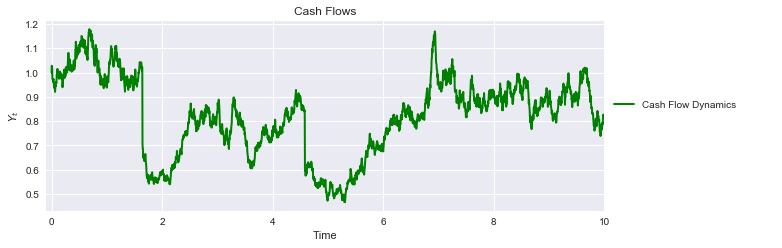

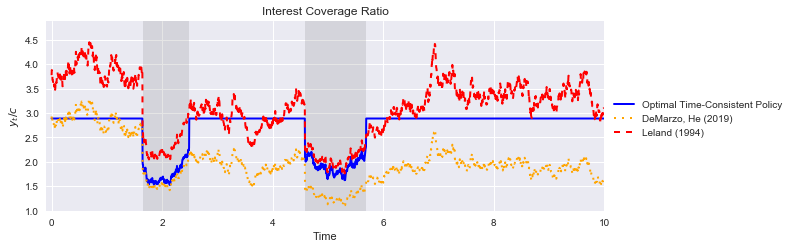

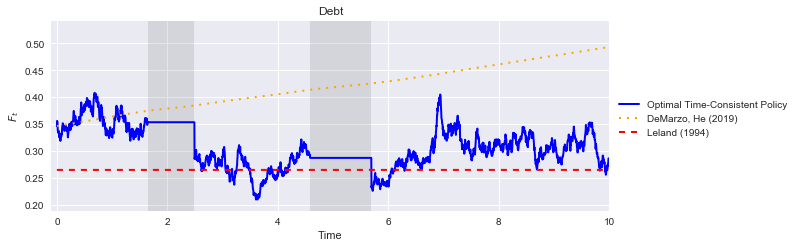

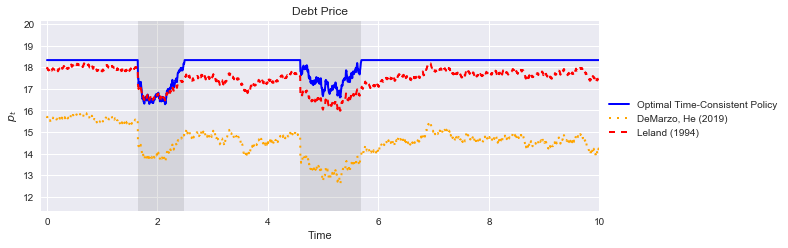

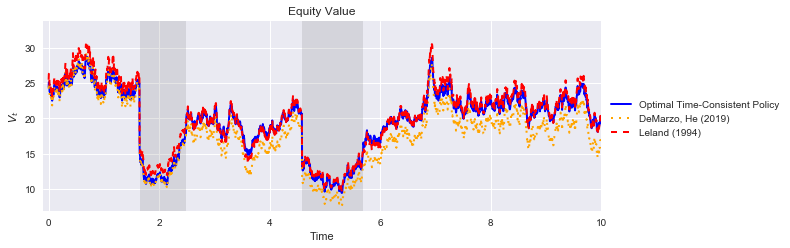

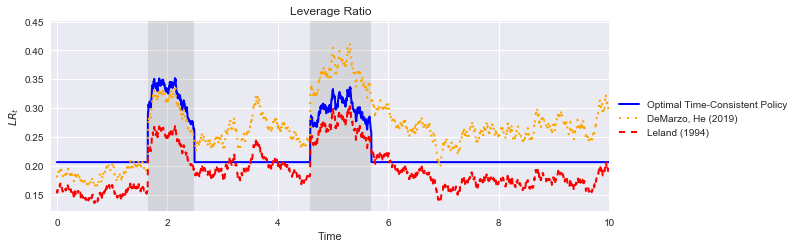

Total running time: 786.09 ms


In [4]:
yha0 = 2.88687
yr0  = 2.31472
yb0  = 0.2888

simulated_lvrg(yha = yha0, yr = yr0, yb = yb0,
               Y0=1, F0=1/yha0, T=10, μ=0.02, σ=0.25, λ=1/3, η=17/3, τ=.1, r = .05, Nsteps=10*252, Nsim=1, seed=11)

0.016398593313429976
-inf
0.03301533250317757


/Users/atsoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning: divide by zero encountered in true_divide


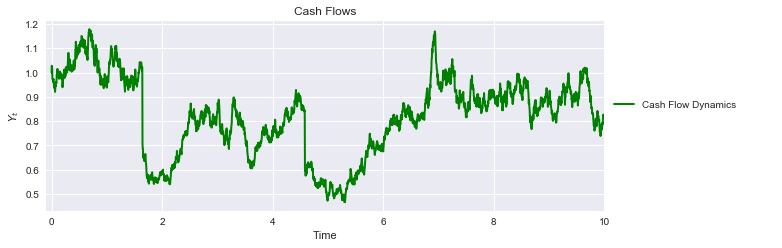

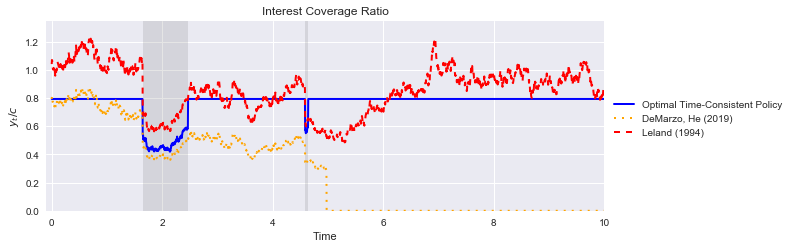

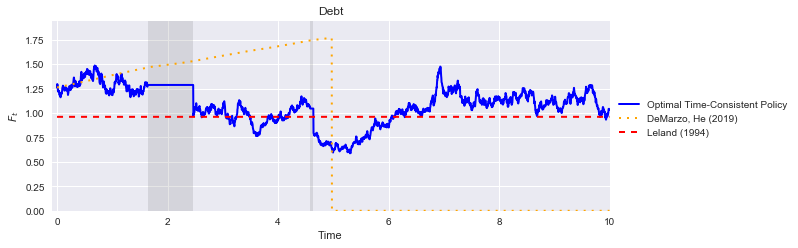

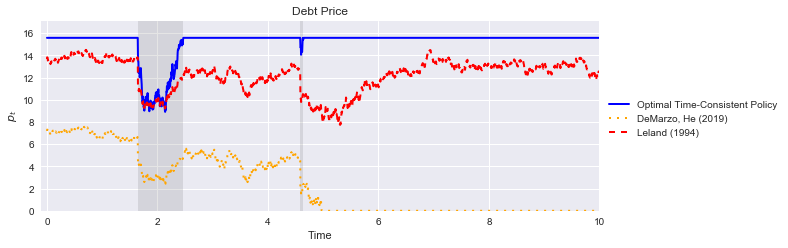

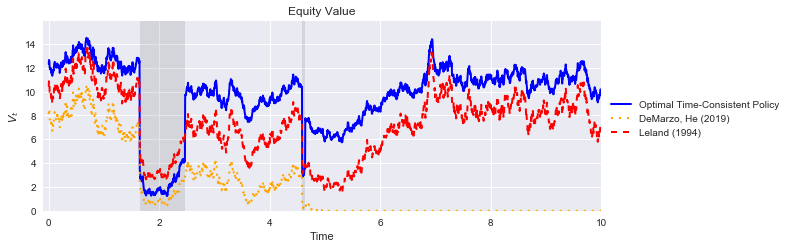

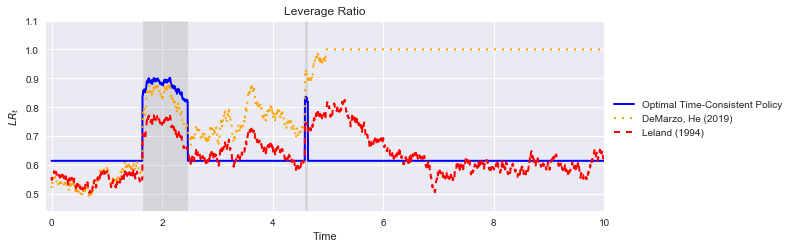

Total running time: 1199.78 ms


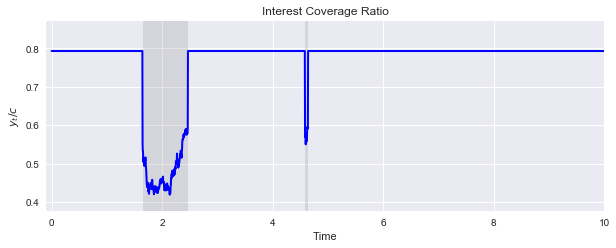

In [8]:
yha0 = 0.79306
yr0  = 0.59609
yb0  = 0.28245

simulated_lvrg(yha = yha0, yr = yr0, yb = yb0,
               Y0=1, F0=1/yha0, T=10, μ=0.02, σ=0.25, λ=1/3, η=17/3, τ=.4, r = .05, Nsteps=10*252, Nsim=1, seed=11)

In [2]:
def generic_pol(yi,yist,yrst,yrov,yr,yb , Y0=1, F0=1, T=1, μ=0.02, σ=0.25, λ=1/3, η=17/3, τ=.1, r = .05, Nsteps=252, Nsim=1, seed=None):                   
    # compute parameters of the model
    ζ = η/(η+1)-1
    μhat = μ-ζ*λ
    σ2 = σ**2
    ϕ = (1-τ)/(r-μ)
    ρ = (1-τ)/r
    coefγ = [-σ2/2, μhat-σ2/2+σ2*η/2, r+λ-μhat*η+σ2*η/2, -r*η]
    γs = sorted(np.roots(coefγ)); γ0 = γs[0]; γ1 = γs[1]; γ2 = γs[2]
    # Set random seed
    np.random.seed(seed)
    tic = time.time()
    Delta_t = T/Nsteps # Calculate the length of the time step
    Y_path  = np.zeros(Nsteps+1) # path of cash flows
    yt_path = np.zeros(Nsteps+1) # path of ICR
    F_path  = np.zeros(Nsteps+1) # debt dynamics
    int_yt  = 0 # auxiliary quantity equal to the new yt if there is no debt issuance/repurchase
    # Replace the first column of the array with the vector of initial price S
    Y_path[0] = Y0
    F_path[0] = F0 
    yt_path[0] = Y0/F0
    # draw shocks
    Z_1 = np.random.normal(0,1,Nsteps)
    Z_2 = np.random.exponential(1/η, Nsteps)
    Poisson = np.random.poisson(λ*Delta_t, Nsteps)
    # Populate the matrix with Nsim randomly generated paths of length Nsteps
    for i in range(Nsteps):
        # fill out path for Yt
        Y_path[i+1] = (yt_path[i]<=yb) * Y_path[i] \
              + (yt_path[i]>yb) * Y_path[i] *np.exp((μhat- σ2/2)*Delta_t \
              + σ*np.sqrt(Delta_t)*Z_1[i] \
              - (Poisson[i]==1) * Z_2[i])
        # equilibrium dynamics
        # auxiliary yt if there was no additional debt issuance/repurchase
        int_yt = yt_path[i]*np.exp((μhat-σ2/2)*Delta_t \
              + σ*np.sqrt(Delta_t)*Z_1[i] \
              - (Poisson[i]==1) * Z_2[i])
        yt_path[i+1] = (yt_path[i]<=yb)*yt_path[i]+(yt_path[i]>yb)*(\
                 (int_yt>=yi)*yist+\
                 (yr<=int_yt<=yrov)*yrst+\
                 ((yrov<int_yt<yi)+(yb<int_yt<yr))*int_yt)
        F_path[i+1] = (yt_path[i]>yb) * (((yrov<int_yt<yi)+(yb<int_yt<yr))*F_path[i] \
                + ((int_yt>=yi)+(yr<=int_yt<=yrov)) * Y_path[i+1]/(yt_path[i+1]+zero))

    # plot Y 
    sns.set(palette='viridis')
    plt.figure(figsize=(10,3.5))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1)
    Y_process = ax.plot(t, Y_path.transpose());
    plt.setp(Y_process, linewidth=2,color='green', label='Cash Flow Dynamics             ');
    ax.set(title="Cash Flows", xlabel='Time', ylabel='$Y_t$')
    plt.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.) 
    plt.xlim((-.1,10))
    plt.show()        

    # plot yt
    sns.set(palette='viridis')
    plt.figure(figsize=(10,3.5))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1)
    yt_process = ax.plot(t, yt_path.transpose());
    plt.setp(yt_process, linewidth=2,color='blue',label='Optimal Time-Consistent Policy');
    # determine range of ys
    miny = min(yt_path); 
    maxy = max(yt_path); 
#     trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)    
#     ax.fill_between(t, 0.1, 5, where=yt_path < yha,
#                 facecolor='gray', alpha=0.2, transform=trans)
    # highlight turbulent region
#     ax.fill_between(t, miny, maxy, where=yt_path < yha, facecolor='gray', alpha=0.2)                    
#     ax.set(title="Interest Coverage Ratio", xlabel='Time', ylabel='$y_t$')
#     plt.legend(loc='upper right', borderaxespad=0.)
    plt.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)   
    plt.xlim((-.1,10))
    plt.ylim((miny,maxy))    
    plt.show()

    # plot F
    sns.set(palette='viridis')
    plt.figure(figsize=(10,3.5))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1)
    F_process = ax.plot(t, F_path.transpose());
    plt.setp(F_process, linewidth=2, color='blue', label='Optimal Time-Consistent Policy');
    ax.set(title="Debt", xlabel='Time', ylabel='$F_t$')
    # determine range of Fs
    minF = min(F_path) 
    maxF = max(F_path)
    # highlight turbulent region
#     trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
#     ax.fill_between(t, minF, maxF, where=yt_path < yha, facecolor='gray', alpha=0.2)
    plt.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)   
#     plt.legend(loc='upper right', borderaxespad=0.)
    plt.xlim((-.1,10))
    plt.ylim((minF,maxF))      
    plt.show()    
        
    # Time and print the elapsed time
    toc = time.time()
    elapsed_time = toc - tic
    print('Total running time: {:.2f} ms'.format(elapsed_time*1000))

In [ ]:

generic_pol(yi=yi0,yist=yist0,yrst=yrst0,yrov=yrov0,yr=yr0,yb=yb0,
               Y0=1, F0=1/yha0, T=10, μ=0.02, σ=0.25, λ=1/3, η=17/3, τ=.4, r = .05, Nsteps=10*252, Nsim=1, seed=11)